In [1]:
from bw_recipe_2016 import (
    ParticulateMatterFormation,
    get_biosphere_database, 
    extract_recipe,
)

In [2]:
data = extract_recipe()[6]

In [3]:
biosphere = get_biosphere_database()

In [4]:
gw = ParticulateMatterFormation(data, biosphere)

In [5]:
gw.apply_strategies()

Applying strategy: generic_reformat
Applying strategy: fix_unit_string
Applying strategy: name_matcher
Applying strategy: complete_method_name
Applying strategy: add_air_category
Applying strategy: match_multiple
Applied 6 strategies in 0.01 seconds


In [7]:
gw.statistics()

3 methods
87 cfs
6 unlinked cfs


(3, 87, 6)

In [8]:
for x in gw.unlinked:
    print(x['name'])

SO
SO3


In [9]:
comp = gw.compare_to_previous()

In [10]:
[(key, len(comp[key])) for key in comp]

[('found', 7), ('missing', 2), ('reference', 6)]

Present in previous ReCiPe, missing here

In [11]:
sorted(comp['reference'].difference(comp['found']))

['particulates, > 2.5 um, and < 10um']

In [12]:
gw.drop_unlinked()

Applying strategy: drop_unlinked_cfs
Applied 1 strategies in 0.00 seconds


In [13]:
gw.write_methods(overwrite=True)

Wrote 3 LCIA methods with 81 characterization factors


In [15]:
gw.data[2]['name']

('ReCiPe 2016', 'v1.1 (20180117)', 'PMFP', 'Egalitarian')

# Compare to previous ReCiPe method

In [16]:
%matplotlib inline

In [17]:
import bw2data, bw2calc
import pyprind
import seaborn as sb
import numpy as np

In [18]:
keys = sorted([x.key for x in bw2data.Database("ecoinvent 3.6 cutoff")])

In [19]:
results_reference, results_2016 = [], []

In [20]:
lca = bw2calc.LCA({keys[0]: 1}, gw.previous_reference)
lca.lci()
lca.lcia()

In [21]:
reference_cm = lca.characterization_matrix.copy()

In [22]:
lca.switch_method(('ReCiPe 2016', 'v1.1 (20180117)', 'PMFP', 'Egalitarian'))

In [23]:
lca.characterization_matrix.sum(), reference_cm.sum()

(8.739999920129776, 12.5799999833107)

In [24]:
new_cm = lca.characterization_matrix.copy()

In [25]:
for key in pyprind.prog_bar(keys):
    lca.redo_lci({key: 1})
    results_reference.append((reference_cm * lca.inventory).sum())
    results_2016.append((new_cm * lca.inventory).sum())    

0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:05:09


/Users/cmutel/miniconda3/envs/bw2dev/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


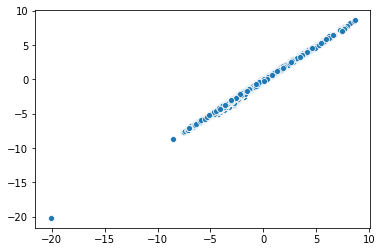

In [26]:
sb.scatterplot(np.log10(np.array(results_reference)), np.log10(np.array(results_2016)))

In [27]:
def masked_ratio(a, b):
    a, b = np.array(a), np.array(b)
    mask = (a != 0) * (b != 0)
    return a / b

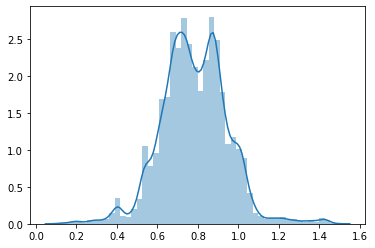

In [28]:
sb.distplot(masked_ratio(results_2016, results_reference))

In [29]:
def abnormal_ratio(a, b):
    if not a or not b:
        return
    ratio = abs(a / b)
    if 0.8 < ratio < 1.25:
        return
    return ratio

In [30]:
exceptions = sorted([
    (abnormal_ratio(results_2016[i], results_reference[i]), bw2data.get_activity(key)) 
    for i, key in enumerate(keys) 
    if abnormal_ratio(results_2016[i], results_reference[i])
], reverse=True)